In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload  
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms as T
from analysis.image import show_image
from datamodules.datasets import get_datasets
from torchinfo import summary
from easydict import EasyDict as edict
from tqdm import tqdm

from sklearn.manifold import TSNE

# Datasets

In [6]:
DATASETS = get_datasets(
    root='/home/nazir/datasets',
    transforms=edict(
        CIFAR10=T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])
        ]),
        CELEBA=T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.5, 0.5, 0.5], std=[1.0, 1.0, 1.0])
        ])
        )
)

Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/nazir/datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


# Loading the Model


In [6]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)

Using cache found in /home/nazir/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [7]:
_ = dinov2_vits14.eval()
_ = dinov2_vits14.cuda()

# Initial Tests

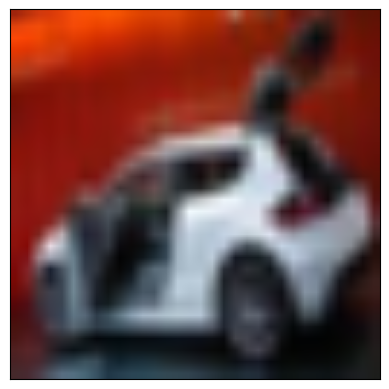

In [85]:
x, y = DATASETS.CIFAR10[6]

show_image(x + 0.5)

In [86]:
with torch.no_grad():
    output = dinov2_vits14.forward_features(x.unsqueeze(0).cuda())

In [87]:
output.keys()

dict_keys(['x_norm_clstoken', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [88]:
output['x_prenorm'].shape, output['x_norm_patchtokens'].shape, output['x_norm_clstoken'].shape

(torch.Size([1, 257, 384]), torch.Size([1, 256, 384]), torch.Size([1, 384]))

In [94]:
avg_pool = nn.AvgPool1d(kernel_size=4, stride=4)

out = avg_pool(output['x_norm_patchtokens'].squeeze(0).permute(1, 0))

out.shape

torch.Size([384, 64])

# Utils

In [8]:
def get_features(model, x, features_type="x_prenorm"):
    with torch.no_grad():
        output = model.forward_features(x.unsqueeze(0).cuda(), )
    return output[features_type].squeeze(0).cpu().numpy()

# Visualization of Features on CIFAR10

## CLS Token

In [9]:
cls_features = []
labels = []
for i in tqdm(range(len(DATASETS.CIFAR10))):
    x, y = DATASETS.CIFAR10[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    labels.extend([y])
    cls_features.extend([features])

cls_features = np.array(cls_features)
labels = np.array(labels)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:57<00:00, 172.69it/s]


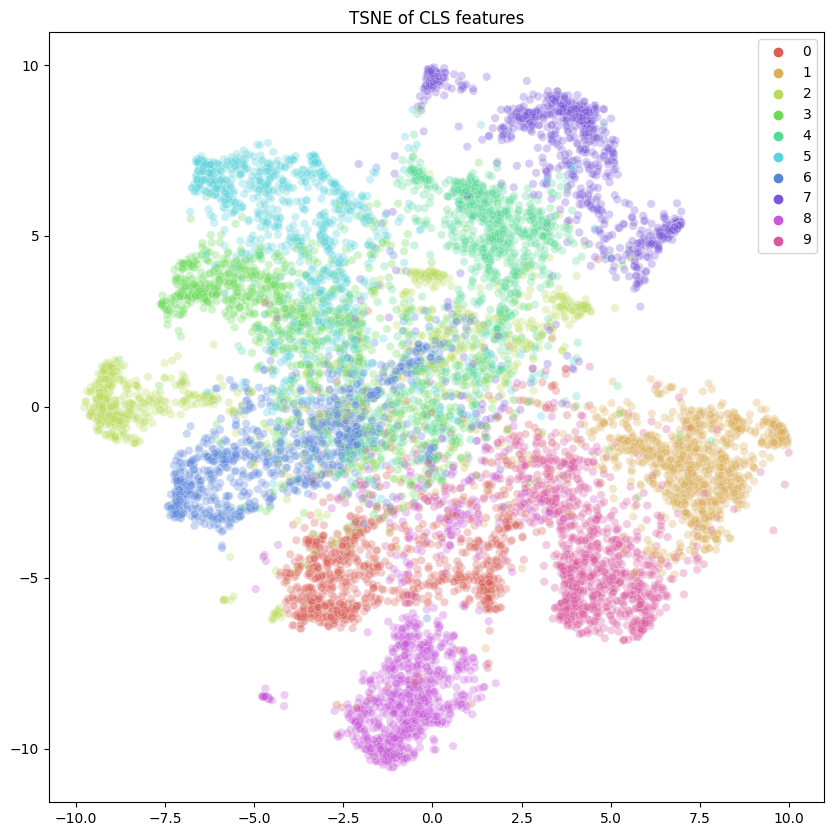

In [10]:
# extract and plot tsne of cls_features

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(cls_features)

tsne_results.shape

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.title("TSNE of CLS features")
plt.show()

## Patch Features Prenorm

patch features are averaged

In [80]:
patch_features_prenorm = []
for i in tqdm(range(len(DATASETS.CIFAR10))):
    x, y = DATASETS.CIFAR10[i]
    features = get_features(dinov2_vits14, x, features_type="x_prenorm")
    patch_features_prenorm.extend([features.mean(axis=0)])

patch_features_prenorm = np.array(patch_features_prenorm)

100%|██████████| 10000/10000 [01:01<00:00, 163.14it/s]


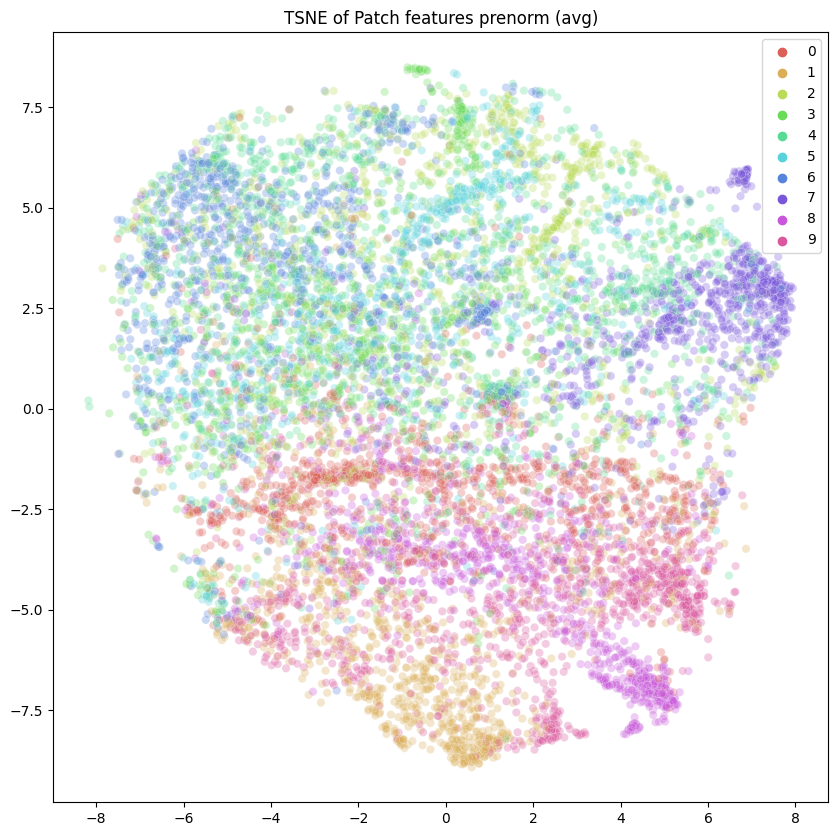

In [81]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results_patch_prenorm = tsne.fit_transform(patch_features_prenorm)

tsne_results.shape

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_results_patch_prenorm[:, 0], y=tsne_results_patch_prenorm[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.title("TSNE of Patch features prenorm (avg)")
plt.show()

## Patch Features Post-Norm

patch features are averaged

In [82]:
patch_features_norm = []
for i in tqdm(range(len(DATASETS.CIFAR10))):
    x, y = DATASETS.CIFAR10[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_patchtokens")
    patch_features_norm.extend([features.mean(axis=0)])

patch_features_norm = np.array(patch_features_norm)

100%|██████████| 10000/10000 [01:04<00:00, 154.54it/s]


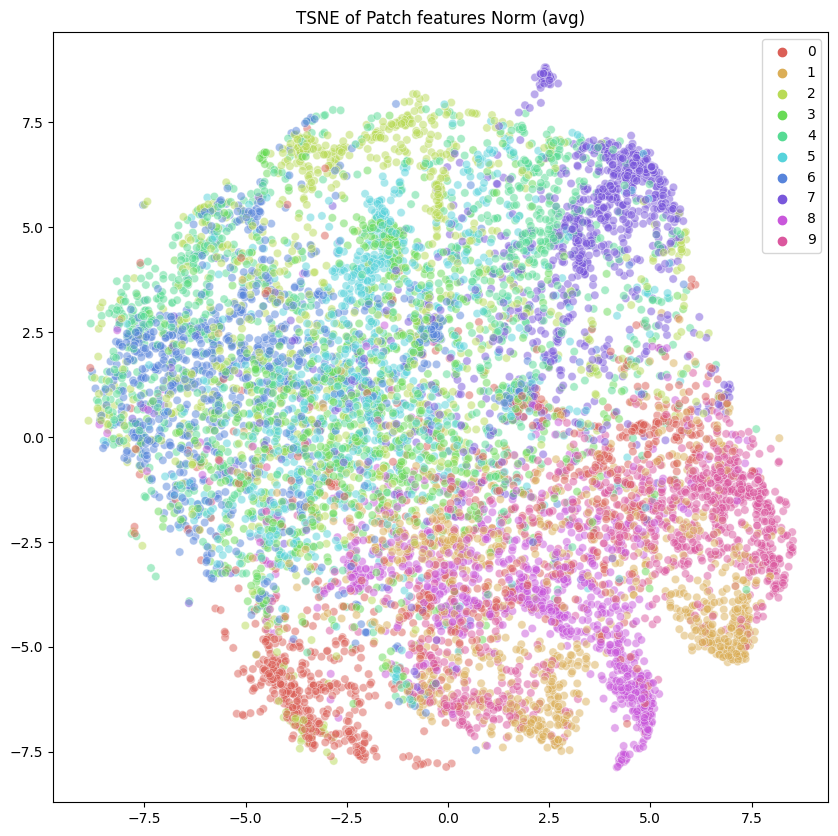

In [83]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results_patch_norm = tsne.fit_transform(patch_features_norm)

tsne_results.shape

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_results_patch_norm[:, 0], y=tsne_results_patch_norm[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.5
)
plt.title("TSNE of Patch features Norm (avg)")
plt.show()

# Quantization of DINO features